In [54]:
import asyncio
from twikit import Client, TooManyRequests
from configparser import ConfigParser
import pandas as pd
from datetime import datetime, timedelta
import re 
import emoji

# Constantes
MINIMUMS = 100
REQUETE = 'ballon d\'or lang:fr '  
# Lire les informations de connexion depuis le fichier config.ini
config = ConfigParser()
config.read('config.ini')
username = config['X']['username']
email = config['X']['email']
password = config['X']['password']

client = Client(language='fr-FR')  # Configurer pour obtenir des résultats en français

# Fonction principale async
async def main():
    # Authentification
    await client.login(auth_info_1=username, auth_info_2=email, password=password)
    
    # Sauvegarder les cookies après l'authentification
    client.save_cookies('cookies.json')
    client.load_cookies('cookies.json')  # Charger les cookies pour les sessions futures

    # Initialisation de la liste pour les tweets et compteur
    donne = []
    tweet_count = 0
    debut = (datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d') 
    fin = datetime.now().strftime('%Y-%m-%d')

    # Rechercher les tweets avec la requête spécifiée
    tweets = await client.search_tweet(REQUETE + f" since:{debut} until:{fin}", product='Top')
  
    
    # Boucle pour paginer les tweets
    while tweet_count < MINIMUMS:
            # Récupérer la page suivante de tweets
            encore = await tweets.next()

            for tweet in encore:
                post_data = {
                    'Texte': tweet.full_text,
                    'Nombre_Likes': tweet.favorite_count,
                    'Nombre_Retweets': tweet.retweet_count,
                    'Followers_Utilisateur': tweet.user.followers_count,
                    'Utilisateur': tweet.user.screen_name,
                    'Date_Publication': tweet.created_at
                }
                donne.append(post_data)
                tweet_count += 1

            
                if tweet_count >= MINIMUMS:
                    break
           
        

    if donne:
        df = pd.DataFrame(donne)
        df.to_csv('tweets_data.csv', index=False)
        print(f"{len(df)} tweets collectés et sauvegardés dans 'tweets_data.csv'")
    else:
        print("Aucune donnée collectée.")

# Exécuter la fonction async
await main()




100 tweets collectés et sauvegardés dans 'tweets_data.csv'


In [55]:

donne = pd.read_csv('tweets_data.csv')
donne.head()

#appliquer des nettoyages
def netoyer(text): 
    text = re.sub(r'http\S+', '', text) # Supprimer les liens 
    text = re.sub(r'www\S+', '', text) # Supprimer les liens www 
    text = re.sub(r'@\w+', '', text) # Supprimer les mentions 
    text = re.sub(r'#\w+', '', text) # Supprimer les hashtags 
    text = re.sub(r'\n', ' ', text) # Supprimer les sauts de ligne 
    text = re.sub(r'[^\w\s]', '', text) # Supprimer les caractères de ponctuation 
    text = emoji.replace_emoji(text, '') # Supprimer les emojis return 
    text.strip() # Enlever les espaces inutiles
    return text

#appliquer le netooyage
donne['Texte'] = donne['Texte'].apply(netoyer)
donne['Texte'].head()



0    Cest toujours quand cest un noir qui doit gagn...
1    Le ballon dor féminin cest comme quand on donn...
2    Cest carrément gênant  tout façon cest vini no...
3    Jour de    Golden Boy  Trophée Kopa  Top 10 ba...
4    Rodri ma fait vibrer la saison passée donc je ...
Name: Texte, dtype: object

In [82]:
from transformers import pipeline

# Créer un pipeline d'analyse de sentiment en utilisant DistilBERT
sentiment = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# Analyser un texte
def analyze_sentiment(text): 
    result = sentiment(text)[0] 
    return result['label'], result['score']
donne[['Sentiment_Label', 'Sentiment_Score']] = donne['Texte'].apply(lambda x: pd.Series(analyze_sentiment(x)))
donne[['Texte', 'Sentiment_Label', 'Sentiment_Score']].head()

#enregistre dans le fichier csv
donne.to_csv('tweets_data.csv', index=False)

   
#donne.head()

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


C:\Users\HP\AppData\Local\Temp\ipykernel_33328\3208150997.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment_Label', palette='viridis')


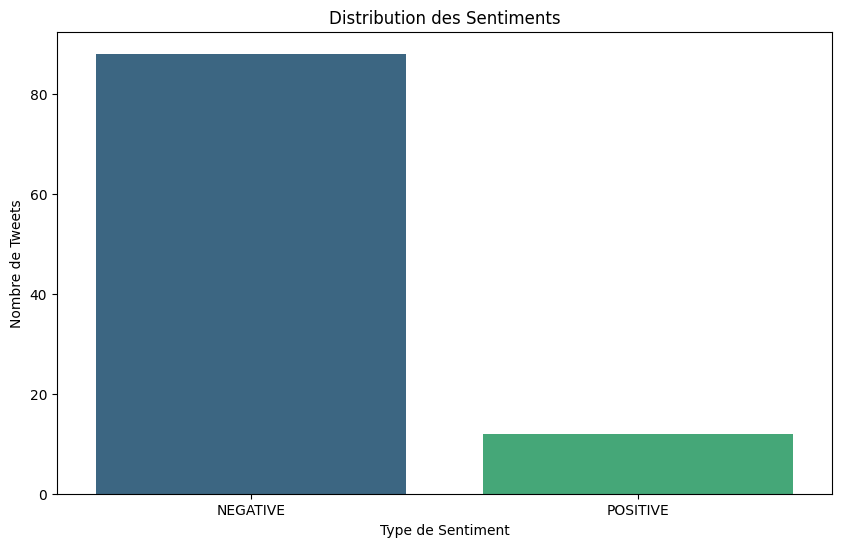

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Charger les données des tweets depuis un fichier CSV (assurant que tu as une colonne 'Sentiment_Label')
df = pd.read_csv('tweets_data.csv')

# Visualisation de la Distribution des Sentiments
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment_Label', palette='viridis')
plt.title('Distribution des Sentiments')
plt.xlabel('Type de Sentiment')
plt.ylabel('Nombre de Tweets')
plt.show()
